## Simple Regression with Keras

### Download Libraries and Clean Dataset

In [1]:
import pandas as pd
import numpy as np

<strong>The dataset is about the compressive strength of different samples of concrete based on the volumes of the different materials that were used to make them. Ingredients include:</strong>  
<strong>1. Cement</strong>  
<strong>2. Blast Furnace Slag</strong>  
<strong>3. Fly Ash</strong>  
<strong>4. Water</strong>  
<strong>5. Superplasticizer</strong>  
<strong>6. Coarse Aggregate</strong>  
<strong>7. Fine Aggregate</strong>  

In [2]:
concrete_data = pd.read_csv('https://ibm.box.com/shared/static/svl8tu7cmod6tizo6rk0ke4sbuhtpdfx.csv')
concrete_data.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


So the first concrete sample has 540 cubic meter of cement, 0 cubic meter of blast furnace slag, 0 cubic meter of fly ash, 162 cubic meter of water, 2.5 cubic meter of superplaticizer, 1040 cubic meter of coarse aggregate, 676 cubic meter of fine aggregate. Such a concrete mix which is 28 days old, has a compressive strength of 79.99 MPa. 

In [3]:
concrete_data.shape

(1030, 9)

So, there are approximately 1000 samples to train our model on. Because of the few samples, we have to be careful not to overfit the training data.

In [4]:
concrete_data.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [5]:
concrete_data.isnull().sum()

Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64

The data looks very clean and is ready to be used to build our model.

#### Split data into predictors and target

In [6]:
concrete_data_columns = concrete_data.columns

predictors = concrete_data[concrete_data_columns[concrete_data_columns != 'Strength']] # all columns except Strength
target = concrete_data['Strength'] # Strength column

<a id="item2"></a>

Let's do a quick sanity check of the predictors and the target

In [7]:
predictors.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360


In [8]:
target.head()

0    79.99
1    61.89
2    40.27
3    41.05
4    44.30
Name: Strength, dtype: float64

Finally, the last step is to normalize the data by substracting the mean and dividing by the standard deviation.

In [9]:
predictors_norm = (predictors - predictors.mean()) / predictors.std()
predictors_norm.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,2.476712,-0.856472,-0.846733,-0.916319,-0.620147,0.862735,-1.217079,-0.279597
1,2.476712,-0.856472,-0.846733,-0.916319,-0.620147,1.055651,-1.217079,-0.279597
2,0.491187,0.795140,-0.846733,2.174405,-1.038638,-0.526262,-2.239829,3.551340
3,0.491187,0.795140,-0.846733,2.174405,-1.038638,-0.526262,-2.239829,5.055221
4,-0.790075,0.678079,-0.846733,0.488555,-1.038638,0.070492,0.647569,4.976069


In [10]:
n_cols = predictors_norm.shape[1] # number of predictors

<a id="item1"></a>

## Import Keras

#### Let's go ahead and import the Keras library

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense

C:\Users\Michael\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Build Neural Network

In [12]:
# define regression model
def regression_model():
    # create model
    model = Sequential()
    model.add(Dense(50, activation='relu', input_shape=(n_cols,)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    
    # compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

<a id="item4"></a>

## Train and Test Network

In [13]:
# build the model
model = regression_model()

# fit the model
model.fit(predictors_norm, target, validation_split=0.3, epochs=100, verbose=0)

In [14]:
predictions = model.predict(predictors_norm) #really should have a separate test set

In [15]:
for i in range(10):
    print(concrete_data.Strength[i], predictions[i])

79.99 [69.01942]
61.89 [69.67367]
40.27 [44.110523]
41.05 [45.202213]
44.3 [37.01221]
47.03 [45.562073]
43.7 [45.71516]
36.45 [37.683983]
45.85 [35.03287]
39.29 [42.048798]


In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

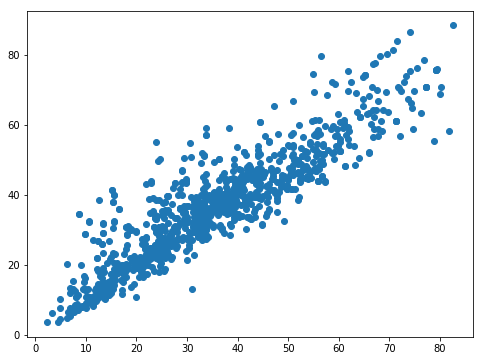

In [17]:
plt.figure(figsize=(8,6))
plt.scatter(concrete_data.Strength, predictions)